In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

This notebook covers how to binscatter plots can be used to observe trends within data. Furthermore, the code at the bottom of this notebook shows how to create a 3D binscatter plot in Python. The data behind this is taken from a dataset with records on a newborn's weight, their mother's weight, and their mother's height. 

**Overview:**
Binscatter plots are a great way to visualize trends within data, especially when working with large amounts of data. By grouping data into buckets and calculating summary statistics (ie. mean, st. dev, etc.) within each group, we can view the relationship between two variables at different levels of grouping. This is especially useful when performing EDA for regressions to understand the correlation between variables and what relationships should hold when viewing results.

In [16]:
# Load data into dataframe
data = pd.read_csv('birthweight.csv')
data

,momweight,babyweight,momheight
0,120,3365,62
1,128,3033,62
2,171,3005,68
3,112,2948,63
4,150,3260,62
...,...,...,...
48866,119,2645,67
48867,133,3860,65
48868,104,3025,63
48869,153,3430,63


We can start by breaking down the weight of the mothers into deciles and calculating the mean of each category in each decile.

In [17]:
# calculate decile cutoffs
deciles = np.percentile(data['momweight'], np.arange(0, 110, 10))
data['decile'] = pd.cut(data['momweight'], deciles)
decile_df = data.groupby(['decile']).agg('mean').reset_index()
decile_df

,decile,momweight,babyweight,momheight
0,"(72.0, 108.0]",100.881829,3154.360253,61.521576
1,"(108.0, 115.0]",112.378797,3240.519322,62.570366
2,"(115.0, 121.0]",119.019051,3281.801176,63.013985
3,"(121.0, 128.0]",125.168889,3316.058148,63.485741
4,"(128.0, 133.0]",130.528451,3348.766325,63.805271
5,"(133.0, 140.0]",137.316565,3377.238521,64.133678
6,"(140.0, 147.0]",144.353901,3395.393948,64.415010
7,"(147.0, 158.0]",152.163640,3422.588630,64.526056
8,"(158.0, 172.0]",164.671812,3444.410869,64.771833
9,"(172.0, 279.0]",187.681497,3507.565489,66.036590


Text(0, 0.5, 'Mean weight of babies')

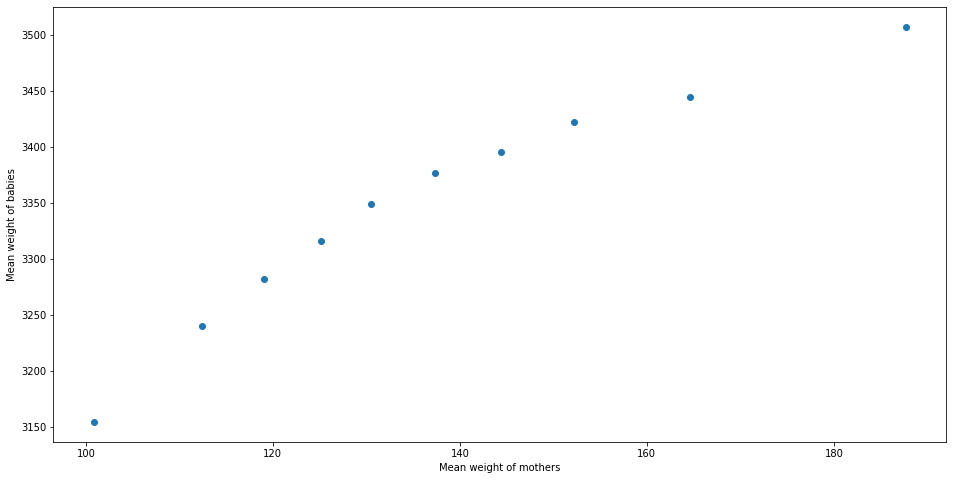

In [18]:
plt.figure(figsize=(16,8))
plt.scatter(decile_df['momweight'], decile_df['babyweight'])
plt.xlabel('Mean weight of mothers')
plt.ylabel('Mean weight of babies')

As can be seen in the above bin-scatter plot, as the mean weight of mothers increases, the mean weight of their babies also seems to increase. This indicates that there is a direct and positive relationship between the weight of the mother and the weight of their baby.

We can also look into how the bin-scatter plot changes when we instead bucket by 1 lb buckets...

In [29]:
# create df by grouping by momweight, which is already rounded to nearest pound
lb_df = data.groupby('momweight').mean().reset_index()
lb_df

,momweight,babyweight,momheight
0,72,2750.000000,61.000000
1,75,2742.166667,57.333333
2,76,3515.000000,54.000000
3,78,2832.000000,60.333333
4,80,2832.944444,59.444444
...,...,...,...
163,248,4241.000000,72.000000
164,252,3320.000000,73.000000
165,260,3761.000000,74.000000
166,265,3695.000000,77.000000


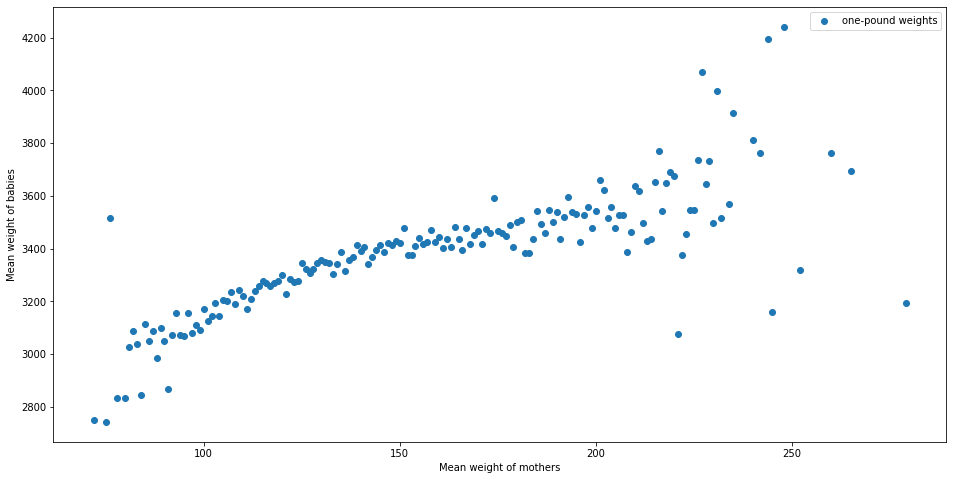

In [30]:
# binscatter
plt.figure(figsize=(16,8))
plt.scatter(lb_df['momweight'], lb_df['babyweight'], label = "one-pound weights")
plt.xlabel('Mean weight of mothers')
plt.ylabel('Mean weight of babies')
plt.legend()

The trend seems to be the same as the decile bin-scatter, as the mean mothers weight increases, the mean baby weight seems to increase with it. The main difference here is that at higher values of mean mother weight, the variability in the datapoints increases. Furthermore, we have a lot more points in this graph since we are grouping by individual one-pound weights as opposed to to deciles. This graph shows that the trend seems to hold well for mean mother weights under 200 but does not hold as strongly for mean mother weights above 200.

Now that we can see how the general trend holds, let's try to find more specific patterns in the underlying data. We will start by dividing mothers' weights into 5 pound buckets (starting at 95), and calculating mean babyweights for 4 separate groups within each bucket: 

1. momheight ≤ 60 inches 
2. momheight between 61 and 63 inches 
3. momheight between 64 and 66 inches 
4. momheight ≥ 67 inches 

We will compare these groups to the midpoint weight in each bucket as well. 

In [34]:
# resetting dataframe 
data = pd.read_csv('birthweight.csv') 

# calculate midpoints
def calculate_midpoint(x): 
    return x.left + (x.right - x.left)/2

In [35]:
# create 5-lb buckets and find midpoint in each bucket 

buckets = np.arange(95, max(df['momweight']), 5)

data['buckets'] = pd.cut(data['momweight'], buckets, include_lowest = True)
data['midpoint'] = data['buckets'].apply(calculate_midpoint)
data

,momweight,babyweight,momheight,buckets,midpoint
0,120,3365,62,"(115.0, 120.0]",117.5
1,128,3033,62,"(125.0, 130.0]",127.5
2,171,3005,68,"(170.0, 175.0]",172.5
3,112,2948,63,"(110.0, 115.0]",112.5
4,150,3260,62,"(145.0, 150.0]",147.5
...,...,...,...,...,...
48866,119,2645,67,"(115.0, 120.0]",117.5
48867,133,3860,65,"(130.0, 135.0]",132.5
48868,104,3025,63,"(100.0, 105.0]",102.5
48869,153,3430,63,"(150.0, 155.0]",152.5


In [38]:
# find means for each subgroup within buckets 
momheight_less_60 = [] 
momheight_bw_6163 = [] 
momheight_bw_6466 = [] 
momheight_more_67 = [] 

for i in range(len(buckets)): 
    # create smaller dataframes for each bucket to perform calculations on
    if (buckets[i] == 95 or buckets[i] == 275):
        continue
    
    if (i == len(buckets) - 1): 
        sub_df = data[data['momweight'] >= buckets[i]]
    else: 
        sub_df = data[(data['momweight'] >= buckets[i]) & (data['momweight'] < buckets[i+1])]
    
    # calculate means for each group within each bucket
    less_60_df = sub_df[sub_df['momheight'] <= 60]
    momheight_less_60.append(less_60_df['babyweight'].mean())
    
    bw_6163_df = sub_df[(sub_df['momheight'] >= 61) & (sub_df['momheight'] <= 63)]
    momheight_bw_6163.append(bw_6163_df['babyweight'].mean())
    
    bw_6466_df = sub_df[(sub_df['momheight'] >= 64) & (sub_df['momheight'] <= 66)]
    momheight_bw_6466.append(bw_6466_df['babyweight'].mean())
    
    more_67_df = sub_df[sub_df['momheight'] >= 67]
    momheight_more_67.append(more_67_df['babyweight'].mean())

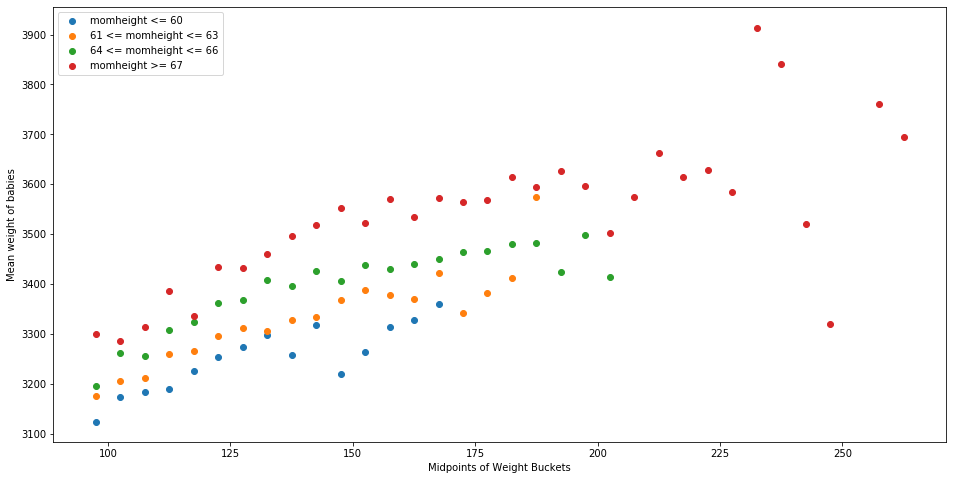

In [40]:
# plot bin-scatter
midpoints = np.sort(data['midpoint'].unique())

plt.figure(figsize=(16,8))
plt.scatter(midpoints, momheight_less_60, label = 'momheight <= 60')
plt.scatter(midpoints, momheight_bw_6163, label = '61 <= momheight <= 63')
plt.scatter(midpoints, momheight_bw_6466, label = "64 <= momheight <= 66")
plt.scatter(midpoints, momheight_more_67, label = "momheight >= 67")
plt.xlabel('Midpoints of Weight Buckets')
plt.ylabel('Mean weight of babies')
plt.legend()

Looking at the graph above we can see that a higher height and weight of the mother suggests that there will be a higher baby weight. Not only do the mean baby weights increase with the mean mother weight, we can see with the color differences highlighting the height difference that higher heights seem to also correspond with higher baby weights. We can see a clear distinction between the 4 height groups and mean babyweights seem to be higher with higher mother heights as well. The group of mothers with a height >= 67 inches shows extremely high variability, however, at higher levels of weight. Thus, while the observed trend holds for lower weights, the increasing variability decreases its predictive power at higher levels of weight and height.

**3D Binscatter**

This section covers how we would approach creating a 3D binscatter using this dataset in Python.

In [42]:
from scipy.stats import percentileofscore

# resetting everything 
data = data[['momweight', 'babyweight', 'momheight']]

# break weight and height into percentiles (incremental of 5)
data['weight_quantiles'] = pd.qcut(data['momweight'], 5, labels=False)
data['height_quantiles'] = pd.qcut(data['momheight'], 5, labels=False)

# group by two different columns, since we want to see a 3d plot, with the two groups on 
# the axes of interest
data_3d = data.groupby(['weight_quantiles', 'height_quantiles']).mean().reset_index()
data_3d

,weight_quantiles,height_quantiles,momweight,babyweight,momheight
0,0,0,105.224693,3164.579417,60.540172
1,0,1,107.826496,3214.547411,63.000000
2,0,2,108.238556,3246.448063,64.000000
3,0,3,109.257032,3264.373424,65.379243
4,0,4,109.196013,3314.873754,67.867110
5,1,0,121.832388,3255.371703,60.957111
6,1,1,122.210868,3281.493798,63.000000
7,1,2,122.306422,3306.666667,64.000000
8,1,3,122.584623,3355.996505,65.444333
9,1,4,123.115222,3391.171247,67.702960


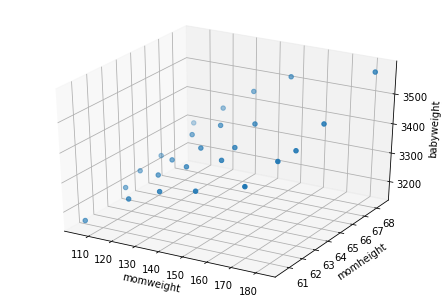

In [43]:
# the below code shows how to display the 3D binscatter! 
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

sequence_containing_x_vals = data_3d['momweight']
sequence_containing_y_vals = data_3d['momheight']
sequence_containing_z_vals = data_3d['babyweight']

ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals)
ax.set_xlabel("momweight")
ax.set_ylabel("momheight")
ax.set_zlabel("babyweight")
plt.show()